In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
import exoplanet as xo

In [0]:
%matplotlib inline

## Get and Prepare data

In [0]:
pathto = 'http://ogledb.astrouw.edu.pl/~ogle/OCVS/data/I/48/OGLE-LMC-RRLYR-00048.dat'

t,y,yerr = np.loadtxt(pathto,unpack=True)

# From OGLE
P_1 = 0.4997337
T0_1 = 6000.31641

y -= y.mean() # This is needed!

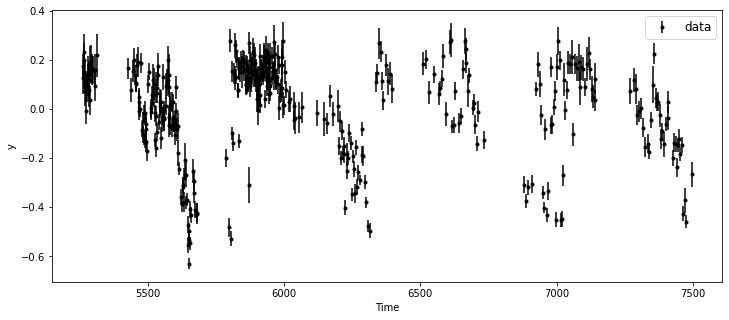

In [6]:
# Check lc
fig = plt.figure(figsize= (12,5) )

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.legend(fontsize=12)
plt.xlabel("Time")
plt.ylabel("y")

plt.show()

In [0]:
def sigma_clip_filtered(time,mag,err,t0,P,sigma=4,window_length=125,polyorder=2):
    dummy_mag = mag.copy()
    dummy_err = err.copy()
    
    phase = (time-t0)%P/P
    phase_sorted = np.sort(phase)
    order = np.argsort(phase)
    dummy_mag_sorted = dummy_mag[order]
    dummy_err_sorted = dummy_err[order]

    dummy_mag_sorted_smoothed = savgol_filter(dummy_mag_sorted,window_length,polyorder)
    dummy_mag_sorted_residual = dummy_mag_sorted - dummy_mag_sorted_smoothed
    
    um =  dummy_mag_sorted_residual > dummy_mag_sorted_residual.mean() + sigma*dummy_mag_sorted_residual.std()
    um2 = dummy_mag_sorted_residual < dummy_mag_sorted_residual.mean() - sigma*dummy_mag_sorted_residual.std()
    
    dummy_mag_sorted[um]  = np.nan
    dummy_mag_sorted[um2] = np.nan
    dummy_err_sorted[um]  = np.nan
    dummy_err_sorted[um2] = np.nan
    
    um_non_nan = np.isfinite(dummy_mag_sorted)
        
    return phase_sorted[um_non_nan],dummy_mag_sorted[um_non_nan],dummy_err_sorted[um_non_nan],dummy_mag_sorted_smoothed[um_non_nan]  


In [0]:
phase_sorted, mag_clean_sorted, err_sorted, mag_fitted = sigma_clip_filtered(t,y,yerr,T0_1,P_1,
                                                                sigma=3,window_length=121,polyorder=2)

In [0]:
# Too close points cause problems in GP fit
phase_sorted[1:][phase_sorted[1:]-phase_sorted[:-1] < 1e-04] = np.nan

um = np.isfinite(phase_sorted)

phase_sorted, mag_clean_sorted, err_sorted, mag_fitted = \
        phase_sorted[um],mag_clean_sorted[um],err_sorted[um],mag_fitted[um]

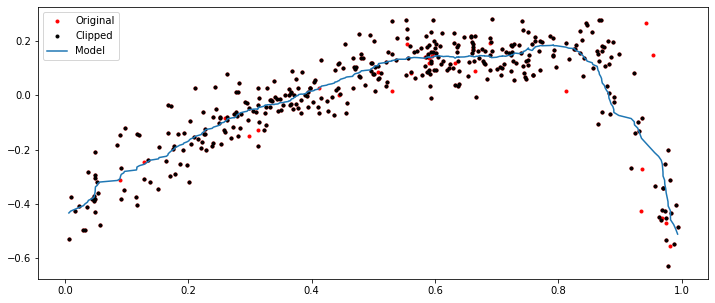

In [10]:
# Check result of sigma clipping and too close point exclusion
fig = plt.figure(figsize= (12,5) )

plt.plot( (t-T0_1)%P_1/P_1 , y, 'r.',label='Original')
plt.plot(phase_sorted,mag_clean_sorted,'k.',label='Clipped')
plt.plot(phase_sorted,mag_fitted,label='Model')
plt.legend()
plt.show()

## Fit GP model

In [0]:
def fit_GP_model(t,y,yerr):
    
    with pm.Model() as model:
        # The mean mag of the time series
        mean = pm.Normal("mean", mu=0.0, sigma=0.1,testval=0)

        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.ptp(y)/2), sd=0.1,testval=np.log(np.ptp(y)/2))
        logperiod = pm.Normal("logperiod", mu=np.log(1), sd=0.1,testval=np.log(1))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0 , testval=-15)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = xo.distributions.UnitUniform("mix")

        # Track the period as a deterministic
        period = pm.Deterministic("period", tt.exp(logperiod))
        amp = pm.Deterministic("amp", tt.exp(logamp))

        kernel = xo.gp.terms.RotationTerm(
                log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
            )
        gp = GP(kernel, t, yerr ** 2, mean=mean)

        # Condition the GP on the observations and add the marginal likelihood
        # to the model
        gp.marginal("gp", observed=y)
        
        
    #Let’s fit for the maximum a posteriori (MAP) parameters
    map_soln = xo.optimize(start=model.test_point,model=model)
    
    return map_soln, model, gp

In [12]:
map_soln, model, gp = fit_GP_model(phase_sorted, mag_clean_sorted, err_sorted)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, mean]
26it [00:01, 19.46it/s, logp=4.129467e+02] 
message: Optimization terminated successfully.
logp: -87.49098020655475 -> 412.946657553267


### Check fit's result

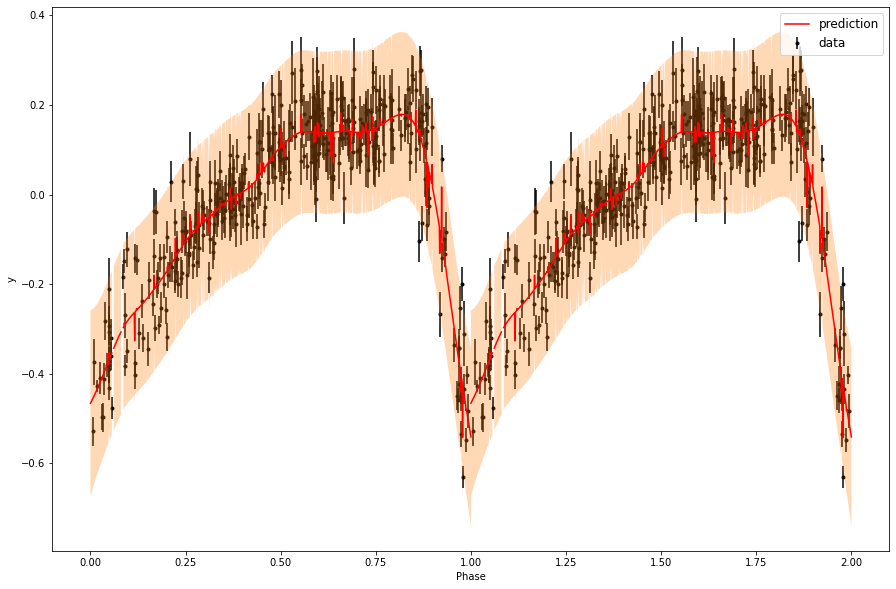

In [13]:
t_for_plotting = np.linspace(0, 1, 1000)  # Dummy phase values for plotting

#We’ll use the exoplanet.eval_in_model() function to evaluate the MAP GP model.
with model:
    mu, var = xo.eval_in_model(
        gp.predict(t_for_plotting, return_var=True, predict_mean=True), map_soln
    )
    
fig = plt.figure(figsize=(15,10))
plt.errorbar(phase_sorted,   mag_clean_sorted, yerr=err_sorted, fmt=".k", capsize=0, label="data")
plt.errorbar(phase_sorted+1, mag_clean_sorted, yerr=err_sorted, fmt=".k", capsize=0)

# Plot the prediction and the 3-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(t_for_plotting, mu + 3*sd, mu - 3*sd, color="C1", alpha=0.3,zorder=5)
art2 = plt.fill_between(t_for_plotting+1, mu + 3*sd, mu - 3*sd, color="C1", alpha=0.3,zorder=5)
art.set_edgecolor("none")
art2.set_edgecolor("none")
plt.plot(t_for_plotting, mu, color="r", label="prediction",zorder=10)
plt.plot(t_for_plotting+1, mu, color="r",zorder=10)

plt.legend(fontsize=12)
plt.xlabel("Phase")
plt.ylabel("y")

plt.show()

## Create dummy lcs

In [0]:
def create_model_lc(t,model,gp,map_soln):
    t_dummy = np.random.random(len(t))
    t_dummy = np.sort(t_dummy)

    with model:
        mu_dummy, var_dummy = xo.eval_in_model(
            gp.predict(t_dummy, return_var=True, predict_mean=True), map_soln
        )

    sd_dummy = np.sqrt(var_dummy)
    
    return t_dummy, mu_dummy, sd_dummy
    
def eval_dummy_lc(t_dummy,mu_dummy,sd_dummy):
    err_dummy = np.random.normal(loc=np.zeros_like(sd_dummy), scale=sd_dummy)
    
    return t_dummy,mu_dummy+err_dummy

In [0]:
phase_model, mu_model, sd_model = create_model_lc(phase_sorted,model,gp,map_soln) # Get model lc

phase_dummy,  y_dummy   = eval_dummy_lc(phase_model, mu_model, sd_model) # Create dummy lc 1
phase_dummy2, y_dummy2  = eval_dummy_lc(phase_model, mu_model, sd_model) # Create dummy lc 2

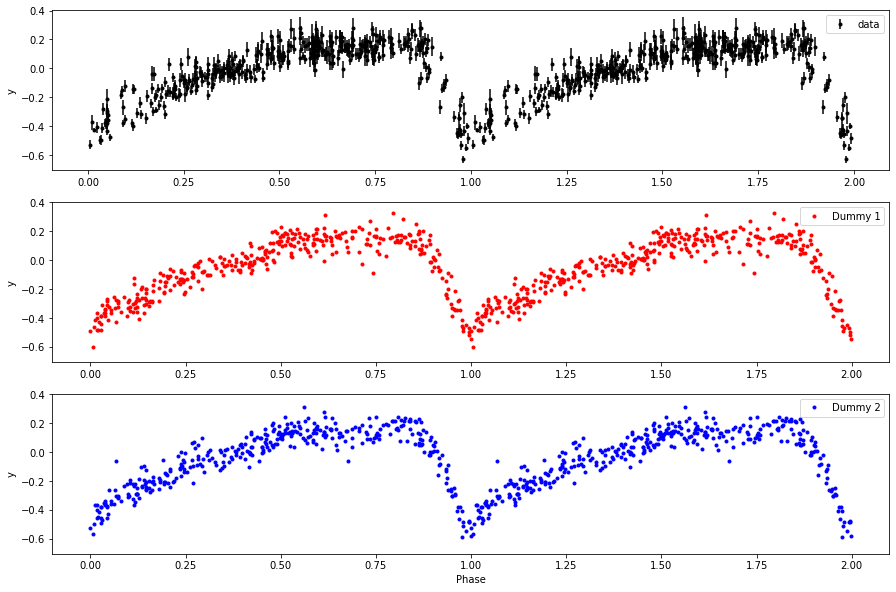

In [16]:
# Check dummy lc
fig,ax = plt.subplots(3,1,figsize=(15,10),sharey=True)

ax[0].errorbar(phase_sorted,   mag_clean_sorted, yerr=err_sorted, fmt=".k", capsize=0, label="data")
ax[0].errorbar(phase_sorted+1, mag_clean_sorted, yerr=err_sorted, fmt=".k", capsize=0)
ax[0].legend(fontsize=12)

ax[1].plot(phase_dummy,    y_dummy, 'r.' , label="Dummy 1")
ax[1].plot(phase_dummy+1,  y_dummy, 'r.')

ax[2].plot(phase_dummy2,   y_dummy2,  'b.', label="Dummy 2")
ax[2].plot(phase_dummy2+1, y_dummy2,'b.')

ax[2].set_xlabel("Phase")
for axn in ax:
    axn.set_ylabel("y")
    axn.legend()

plt.show()